In [34]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
import joblib




In [35]:


df = pd.read_csv(
    "../data/processed/online_retail_clean.csv",
    parse_dates=["InvoiceDate"]
)

df['Revenue'] = df['Quantity'] * df['UnitPrice']

df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


In [36]:
T = df["InvoiceDate"].max() - pd.Timedelta(days=60)

T


Timestamp('2011-10-10 12:50:00')

In [37]:
df_before_T = df[df["InvoiceDate"] <= T] # features
df_after_T = df[df["InvoiceDate"] > T] # labels


In [38]:
df_before_T["InvoiceDate"].max()
df_after_T["InvoiceDate"].min()


Timestamp('2011-10-10 12:51:00')

In [39]:
active_after_T = (
    df_after_T.groupby("CustomerID")
    .size()
    .reset_index(name="tx_count_after_T")
)


In [40]:
customers_before_T = df_before_T["CustomerID"].unique()

labels_df = pd.DataFrame({"CustomerID": customers_before_T})

labels_df = labels_df.merge(
    active_after_T[["CustomerID"]],
    on="CustomerID",
    how="left"
)

labels_df["will_churn_60d"] = labels_df["CustomerID"].apply(
    lambda x: 0 if x in active_after_T["CustomerID"].values else 1
)

labels_df.head()


,CustomerID,will_churn_60d
0,17850,1
1,13047,0
2,12583,0
3,13748,1
4,15100,1


In [41]:
labels_df["will_churn_60d"].value_counts(normalize=True)


will_churn_60d
1    0.520504
0    0.479496
Name: proportion, dtype: float64

In [42]:
recency_df = (
    df_before_T.groupby("CustomerID")["InvoiceDate"]
    .max()
    .reset_index()
)

recency_df["recency_at_T"] = (T - recency_df["InvoiceDate"]).dt.days
recency_df = recency_df[["CustomerID", "recency_at_T"]]

recency_df.head()


,CustomerID,recency_at_T
0,12346,265
1,12347,69
2,12348,14
3,12350,249
4,12352,11


In [43]:
last_30d = T - pd.Timedelta(days=30)
last_90d = T - pd.Timedelta(days=90)


In [44]:
tx_30d = (
    df_before_T[df_before_T["InvoiceDate"] >= last_30d]
    .groupby("CustomerID")
    .size()
    .reset_index(name="tx_30d")
)

tx_90d = (
    df_before_T[df_before_T["InvoiceDate"] >= last_90d]
    .groupby("CustomerID")
    .size()
    .reset_index(name="tx_90d")
)


In [45]:
spend_30d = (
    df_before_T[df_before_T["InvoiceDate"] >= last_30d]
    .groupby("CustomerID")["Revenue"]
    .sum()
    .reset_index(name="spend_30d")
)

spend_90d = (
    df_before_T[df_before_T["InvoiceDate"] >= last_90d]
    .groupby("CustomerID")["Revenue"]
    .sum()
    .reset_index(name="spend_90d")
)


In [46]:
features_df = recency_df.merge(tx_30d, on="CustomerID", how="left") \
                         .merge(tx_90d, on="CustomerID", how="left") \
                         .merge(spend_30d, on="CustomerID", how="left") \
                         .merge(spend_90d, on="CustomerID", how="left")


In [47]:
features_df.fillna(0, inplace=True)


In [48]:
features_df["avg_order_value"] = (
    features_df["spend_90d"] / features_df["tx_90d"].replace(0, 1)
)


In [49]:
features_df["activity_trend"] = (
    features_df["tx_30d"] / features_df["tx_90d"].replace(0, 1)
)


In [50]:
phase2_df = features_df.merge(
    labels_df,
    on="CustomerID",
    how="inner"
)

phase2_df.head()


,CustomerID,recency_at_T,tx_30d,tx_90d,spend_30d,spend_90d,avg_order_value,activity_trend,will_churn_60d
0,12346,265,0.0,0.0,0.0,0.00,0.000000,0.0,1
1,12347,69,0.0,22.0,0.0,584.91,26.586818,0.0,0
2,12348,14,3.0,3.0,310.0,310.00,103.333333,1.0,1
3,12350,249,0.0,0.0,0.0,0.00,0.000000,0.0,1
4,12352,11,32.0,32.0,632.5,632.50,19.765625,1.0,0


In [51]:
phase2_df.isnull().sum()
phase2_df["will_churn_60d"].value_counts(normalize=True)


will_churn_60d
1    0.520504
0    0.479496
Name: proportion, dtype: float64

In [52]:


X = phase2_df[
    [
        "recency_at_T",
        "tx_30d",
        "tx_90d",
        "spend_30d",
        "spend_90d",
        "avg_order_value",
        "activity_trend"
    ]
]

y = phase2_df["will_churn_60d"]


In [53]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [54]:


scaler_p2 = StandardScaler()

X_train_scaled = scaler_p2.fit_transform(X_train)
X_test_scaled = scaler_p2.transform(X_test)


In [55]:


log_reg_p2 = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    random_state=42
)

log_reg_p2.fit(X_train_scaled, y_train)


,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",'balanced'
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",42
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:

In [56]:
# Save Phase 2 scaler
joblib.dump(scaler_p2, "../models/predictive/logistic_scaler_p2.pkl")

# Save Phase 2 predictive model
joblib.dump(log_reg_p2, "../models/predictive/logistic_churn_predictive_p2.pkl")

['../models/predictive/logistic_churn_predictive_p2.pkl']

In [57]:

y_proba = log_reg_p2.predict_proba(X_test_scaled)[:, 1]




In [58]:


roc_auc_p2 = roc_auc_score(y_test, y_proba)
roc_auc_p2


0.7198697419252919

In [59]:
coef_df = pd.DataFrame({
    "feature": X.columns,
    "coefficient": log_reg_p2.coef_[0]
}).sort_values(by="coefficient", ascending=False)

coef_df


,feature,coefficient
3,spend_30d,0.535447
0,recency_at_T,0.482540
6,activity_trend,0.267241
5,avg_order_value,0.196691
1,tx_30d,-0.321986
2,tx_90d,-0.522866
4,spend_90d,-1.723983


In [60]:


thresholds = np.arange(0.1, 0.9, 0.05)

results = []

for t in thresholds:
    y_pred_t = (y_proba >= t).astype(int)

    precision = precision_score(y_test, y_pred_t)
    recall = recall_score(y_test, y_pred_t)
    f1 = f1_score(y_test, y_pred_t)
    pct_flagged = y_pred_t.mean()

    results.append([t, precision, recall, f1, pct_flagged])

threshold_df = pd.DataFrame(
    results,
    columns=["threshold", "precision", "recall", "f1_score", "pct_customers_flagged"]
)

threshold_df


,threshold,precision,recall,f1_score,pct_customers_flagged
0,0.10,0.534341,1.000000,0.696509,0.974565
1,0.15,0.544304,0.994859,0.703636,0.951807
2,0.20,0.553957,0.989717,0.710332,0.930388
3,0.25,0.558003,0.976864,0.710280,0.911647
4,0.30,0.579598,0.964010,0.723938,0.866131
5,0.35,0.591736,0.920308,0.720322,0.809906
6,0.40,0.611212,0.868895,0.717622,0.740295
7,0.45,0.645361,0.804627,0.716247,0.649264
8,0.50,0.662818,0.737789,0.698297,0.579652
9,0.55,0.686016,0.668380,0.677083,0.507363


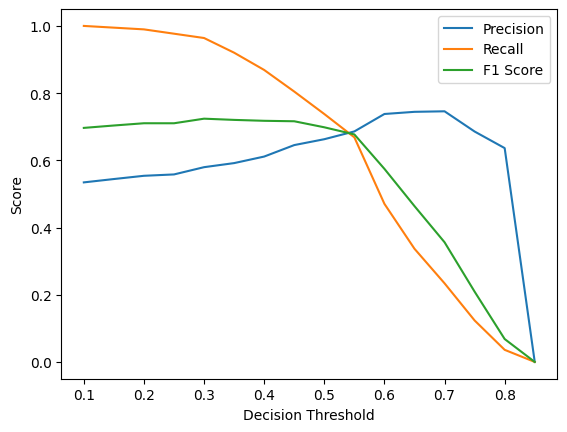

In [61]:


plt.figure()
plt.plot(threshold_df["threshold"], threshold_df["precision"], label="Precision")
plt.plot(threshold_df["threshold"], threshold_df["recall"], label="Recall")
plt.plot(threshold_df["threshold"], threshold_df["f1_score"], label="F1 Score")
plt.xlabel("Decision Threshold")
plt.ylabel("Score")
plt.legend()
plt.show()


In [62]:
CHURN_THRESHOLD = 0.40  # chosen to balance recall and campaign size

y_pred = (y_proba >= CHURN_THRESHOLD).astype(int)